# Spectral sorting and filtering

We are going to filter out very noisy data through the power spectral density of the traces. This exploits the fact that many common types of noise obey a very specific power law of their spectral densities, going like PSD ~ f^a, where a goes from -2 to 0.

For example (and you can get more details at https://en.wikipedia.org/wiki/Colors_of_noise):

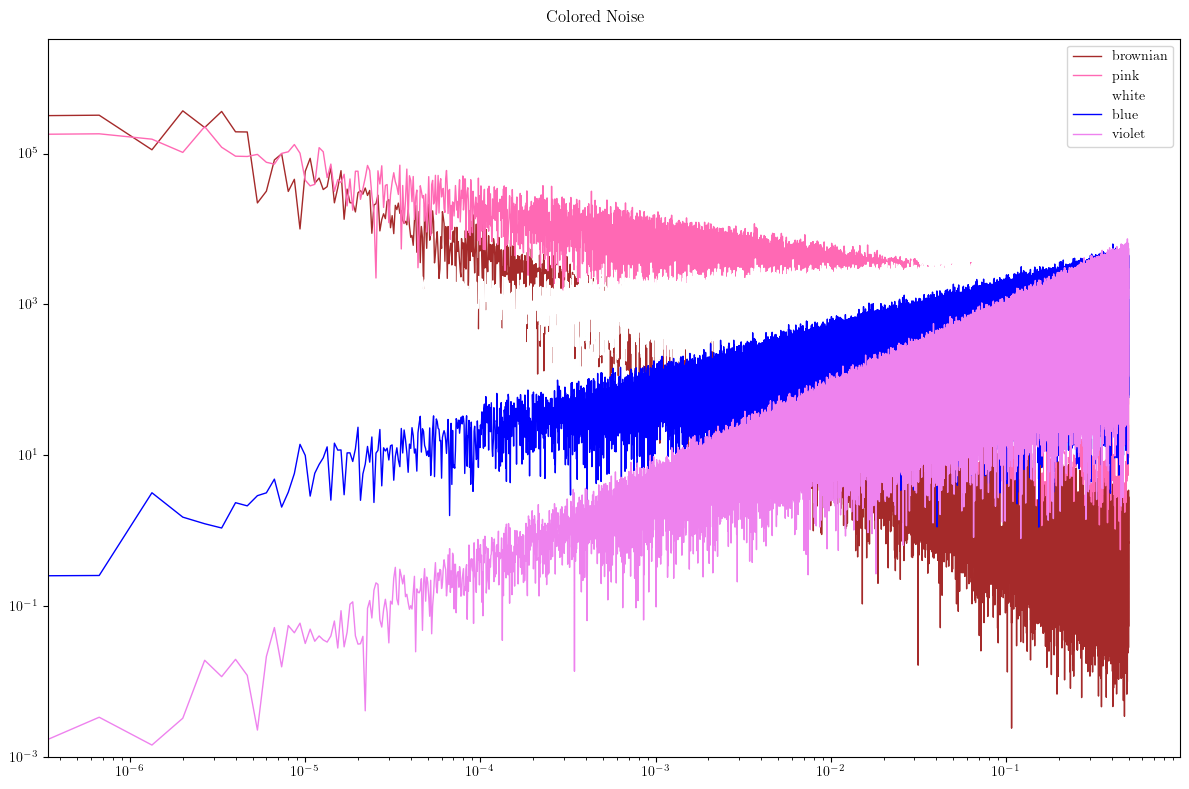

For white (which, btw, doesn't mean gaussian), a = 0. 

For brownian (random walk / Wiener process), a = -2. 

For pink noise (Flicker noise), a = -1. 

Pink noise is known to induce some critical dynamics by inducing self-organized criticality, which induces avalanching behavior and the like, and this type of noise is especially prevalent in neural dynamics. It's an example of multiplicative noise too, which is very important in the study of fat tailed distributions, which give rise to rare and catastrophic events that's of huge importance in nonequlibrium stochastic dynamics.

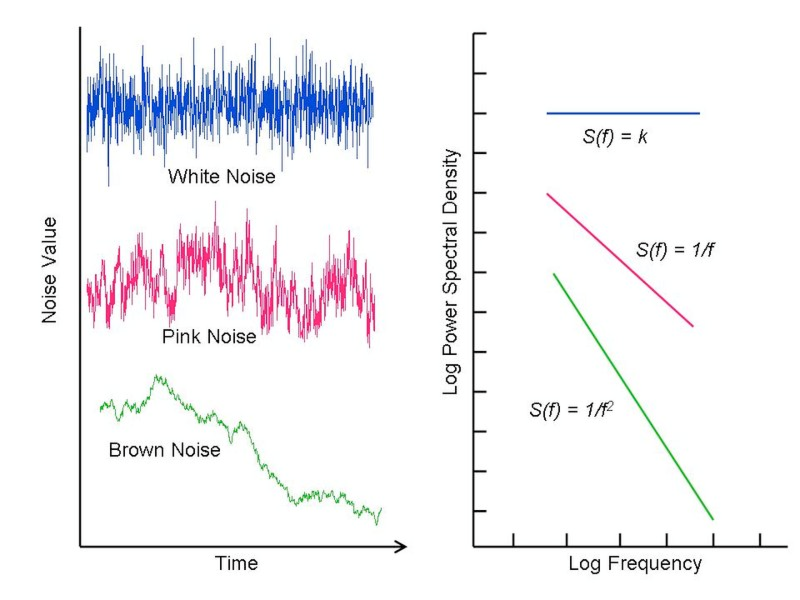


Anyway, let's import the libraries to get started.

In [33]:
import numpy as np
import pandas as pd
import scipy.sparse as sparse
from scipy.stats import pearsonr
from scipy.sparse import linalg
import scipy.sparse
from scipy.linalg import solve, pinv
from scipy.signal import savgol_filter
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import rc
import matplotlib.gridspec as gridspec
from functools import partial
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from numpy.fft import fft2, fftshift, ifft2
from scipy.stats import linregress

from scipy.integrate import solve_ivp
from numpy.random import default_rng

## Data

Calling in some data set as __test__:

In [3]:
test = pd.read_csv("../data/spectral_filtering_test.csv",header=None)
test = test.to_numpy()

test=test[:,2:] # don't need the columns of coordinates for now

Check dimensions of array

In [4]:
test.shape # no. of neurons x time

(7389, 1799)

Plotting a specific trace as an example:

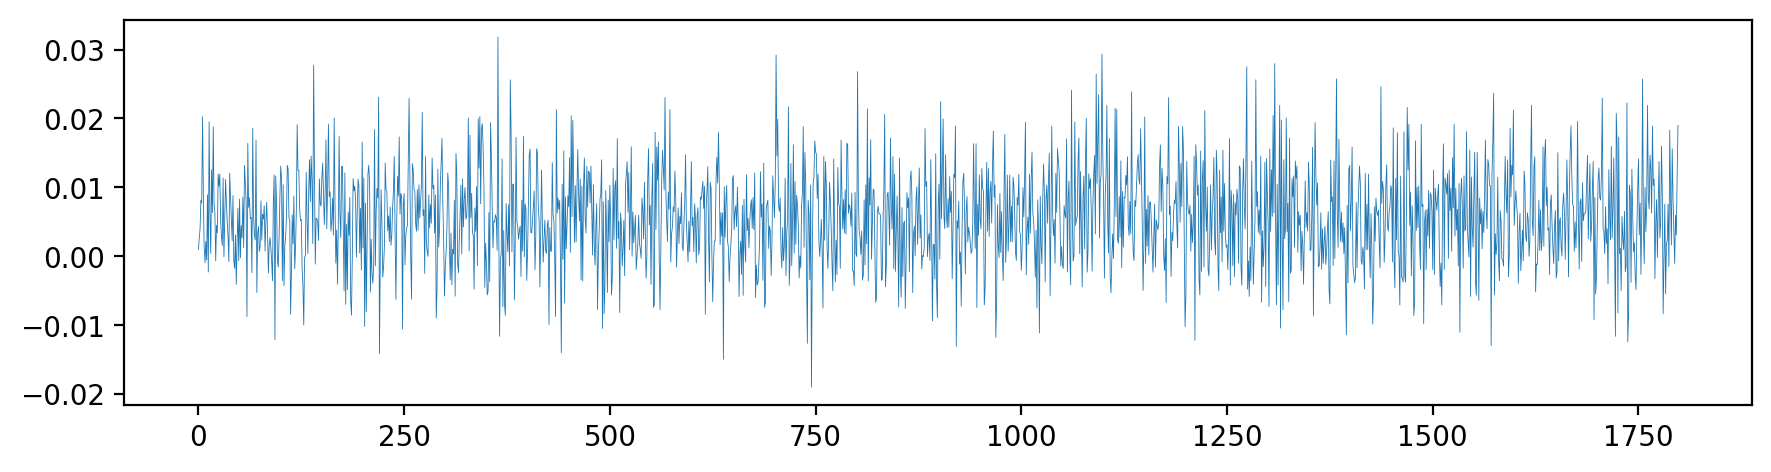

In [5]:
f, (ax0) = plt.subplots(1, figsize=(10.5,2.5), dpi=200,sharex=True)
f.patch.set_facecolor('xkcd:white')

b = ax0.plot(test[1],linewidth=.3)

It looks pretty noisy. To see its PSD (power spectral density), let's run the following:

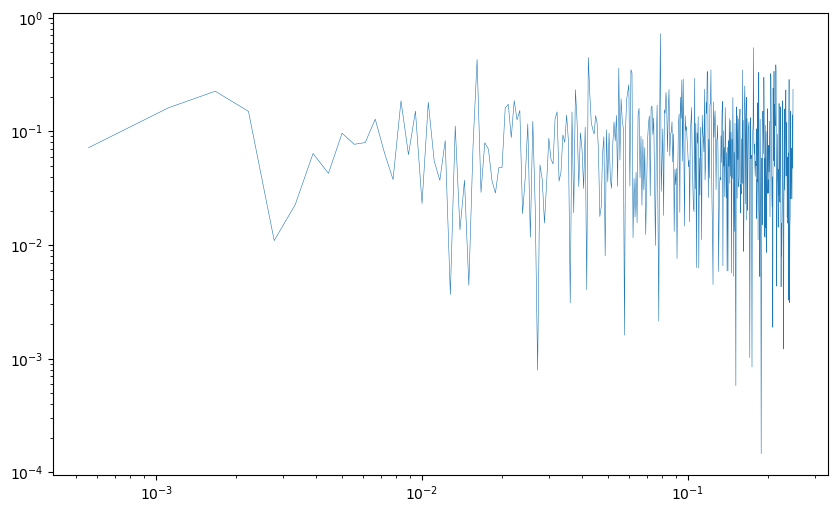

In [16]:
plt.figure(figsize=(10,6))

cutoff = int(np.floor(test[1].shape[0]/2)) 
#to avoid nan in log (plot itself will just not display, or cause a weird horizontal line)

trace=test[1]

f = np.fft.fftfreq(len(trace))
F0 = np.fft.fft(trace)  
P0 = np.abs(F0)     

plt.loglog(f[1:int(cutoff/2)],P0[1:int(cutoff/2)]**2,linewidth=.4) #1 is there to avoid nan.

It looks very noisy, with a slope very close to 0. 

__Before__ we even analyze this, a few words:

1. Notice the "bleeding" that happens with the PSD downwards. This is only due to the loglog nature of the plot. For example, let's say we're plotting values close to 2. 2.1 will look much closer to 2 than 1.9 in a loglog plot. To account for this in our slope-finding (which should give us a, the power spectral exponent), we can either i. get rid of the outliers by imposing a threshold, ii. use regularization in the regression, or iii. be more flexibile with the threshold, knowing that these 'outlying' points will cause the best-fit slope to drop, and don't bother with i or ii.

2. Never look at the portion of the PSD for small frequencies. As an example, the plot above shows the PSD for frequencies of 1e-3 (i.e. period of 1000 frames) ... but your trace is only 1800 frames or so. I don't trust that. So I just start looking at the PSD starting at around 1e-2 (meaning 10 periods per trace), which __is__ a very large number of periods to use as a threshold, but statistically that is very small to begin with, so ... I'm rolling with it lol (keep in mind while central limit theorem applies to >30 ish samples (so 30 periods to get a decent idea of the 'mean' peroid), the student t-test can be used for anything less than that, but of course the statistical effect is that the chance for you to get a false negative of your null-hypothesis is very large for even just 10 samples (https://en.wikipedia.org/wiki/Power_of_a_test <- not the same definition of power as in physics).


Too much blabbering. Anyway, to get the slope:

In [32]:
regress=linregress(np.log(f[14:int(cutoff/2)]), np.log(P0[14:int(cutoff/2)]**2))  #14 is right before period of 1e-2

slope=regress[0]

print(slope)

-0.9761911539636516


As you can see, the value is close to 0, but the bleeding outliers are pushing the slope more negative. 


Let's try this for another trace:

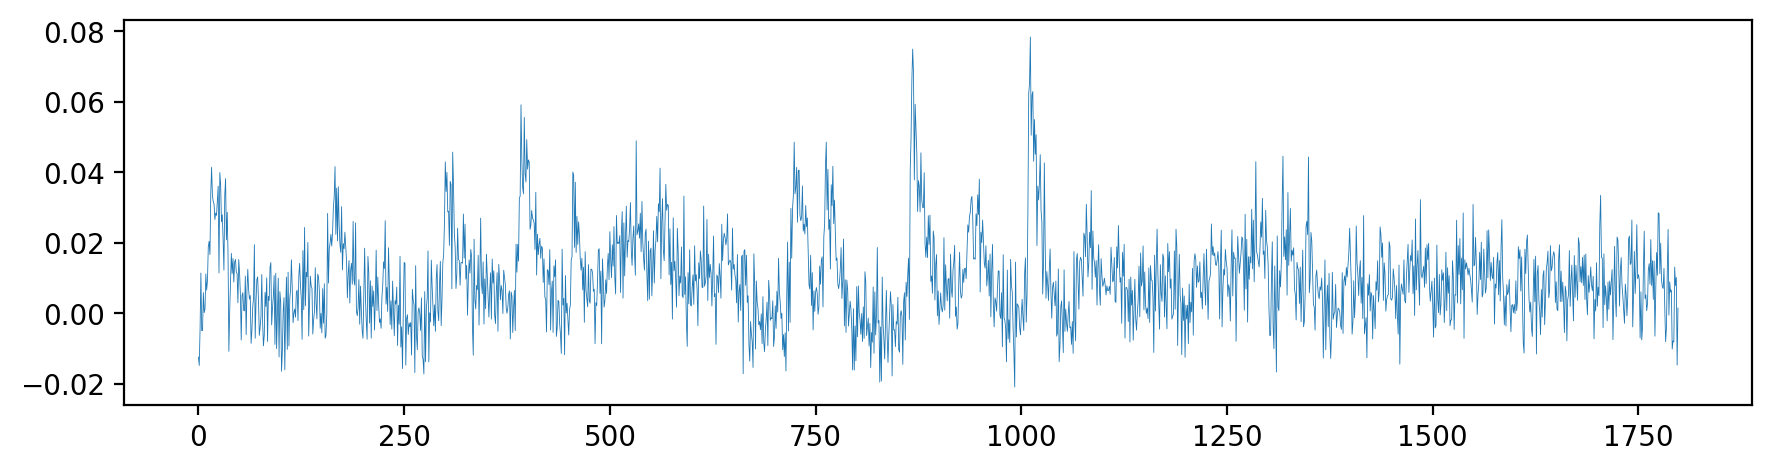

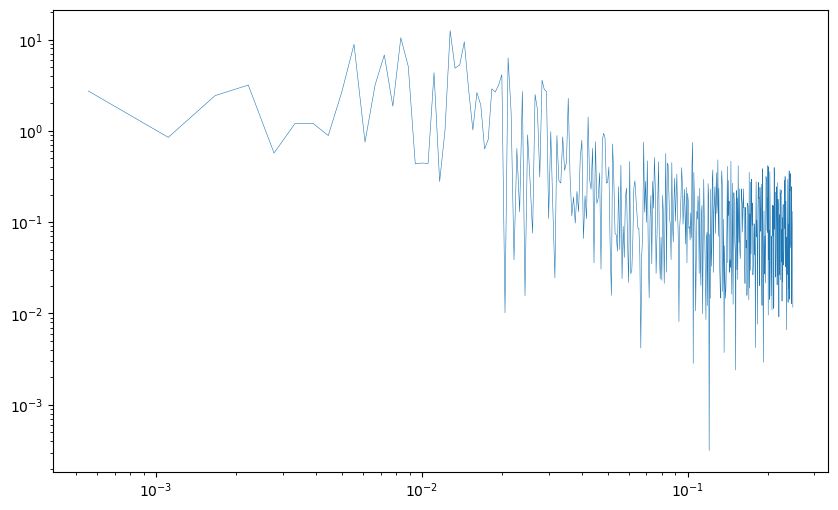

In [31]:
trace=test[120]

f, (ax0) = plt.subplots(1, figsize=(10.5,2.5), dpi=200,sharex=True)
f.patch.set_facecolor('xkcd:white')

b = ax0.plot(trace,linewidth=.3)

##################################

plt.figure(figsize=(10,6))

f = np.fft.fftfreq(len(trace))
F0 = np.fft.fft(trace)  
P0 = np.abs(F0)     

plt.loglog(f[1:int(cutoff/2)],P0[1:int(cutoff/2)]**2,linewidth=.4) #1 is there to avoid nan.

A dramatic difference. Notice that away from DC (f=0), there is a very linear downwards slope, but near the end of the PSD, it flattens again. This corresponds to the white noise that's prevalent in the trace already overtaking the dynamics.

To elucidate, you look at the noise spectra at the top of this notebook, notice that there will be an intersection between white noise and the other types of noise where one will overtake the other. This is because the other types of noise have intensities that are dependent on the frequency, so eventually the intensity of some noises will die to nearly 0 while white remains 'strong'.


We naturally expect the slope to be closer to 0 if we include that part:

-0.9632575626027312


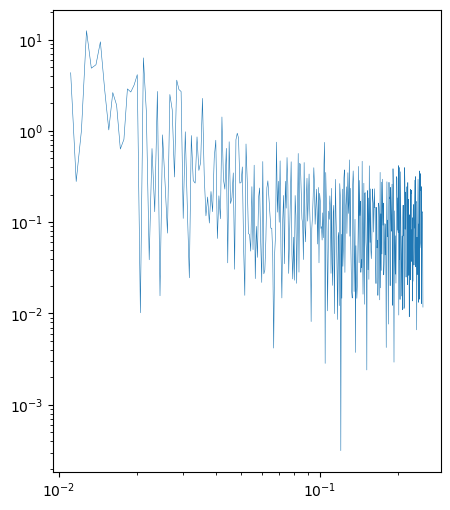

In [45]:

plt.figure(figsize=(5,6))

f = np.fft.fftfreq(len(trace))
F0 = np.fft.fft(trace)  
P0 = np.abs(F0)     

plt.loglog(f[20:int(cutoff/2)],P0[20:int(cutoff/2)]**2,linewidth=.4) #1 is there to avoid nan.

regress=linregress(np.log(f[20:int(cutoff/2)]), np.log(P0[20:int(cutoff/2)]**2))  #20 is right before period of 1e-2

slope=regress[0]

print(slope)

But getting rid of that background white:

-1.5207471032919957


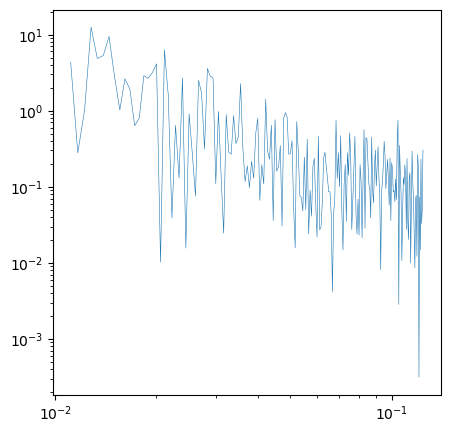

In [43]:

plt.figure(figsize=(5,5))

f = np.fft.fftfreq(len(trace))
F0 = np.fft.fft(trace)  
P0 = np.abs(F0)     

plt.loglog(f[20:int(cutoff/4)],P0[20:int(cutoff/4)]**2,linewidth=.4) #1 is there to avoid nan.

regress=linregress(np.log(f[20:int(cutoff/4)]), np.log(P0[20:int(cutoff/4)]**2))  #14 is right before period of 1e-2

slope=regress[0]

print(slope)

Clearly the trace isn't pure noise, whether it be pink or white or whatever. This is reflected in the slope value, __but__ it is close to -1 (remember, the bleeding will drag the slope down), and the plot looks pretty linear, corresponding to dynamics close to pink noise

# Automating the process through the entire dataset

Mine got the slopes of all 7400ish traces in under 2 seconds---I have a M1 Air, for performance reference.

In [48]:
slope=np.zeros((test.shape[0]))

cutoff = int(np.floor(test[1].shape[0]/2)) #to avoid nan in log (plot itself will just not display)

for i in range(slope.shape[0]):
    
    trace=test[i]

    f = np.fft.fftfreq(len(trace))
    F0 = np.fft.fft(trace)  
    P0 = np.abs(F0)     

    regress=linregress(np.log(f[20:int(cutoff/4)]), np.log(P0[20:int(cutoff/4)]**2)) 
    # any presence of white noise will dominate the power spectrum at high frequencies, since other powers will decay completely by then. 
    # so i'm looking only at the intermediate region simply to detect any presence of deterministic activity
    
    slope[i]=regress[0]

Text(0.5, 1.0, 'histograms of power slope')

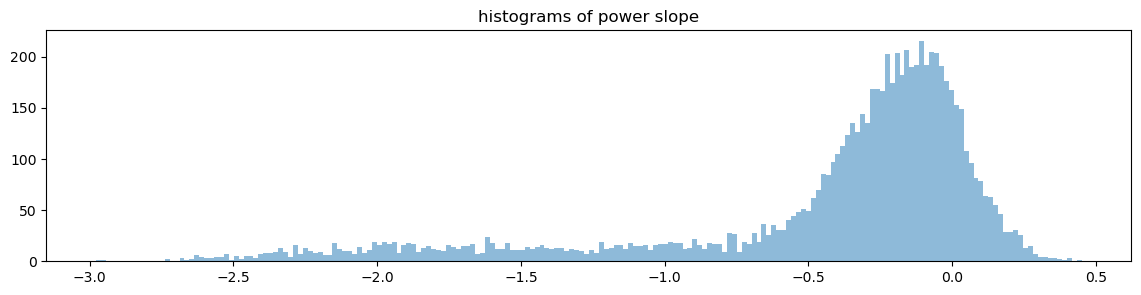

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 3))
ax.hist(slope.ravel(), bins=200,alpha=0.5)
ax.set_title('histograms of power slope')

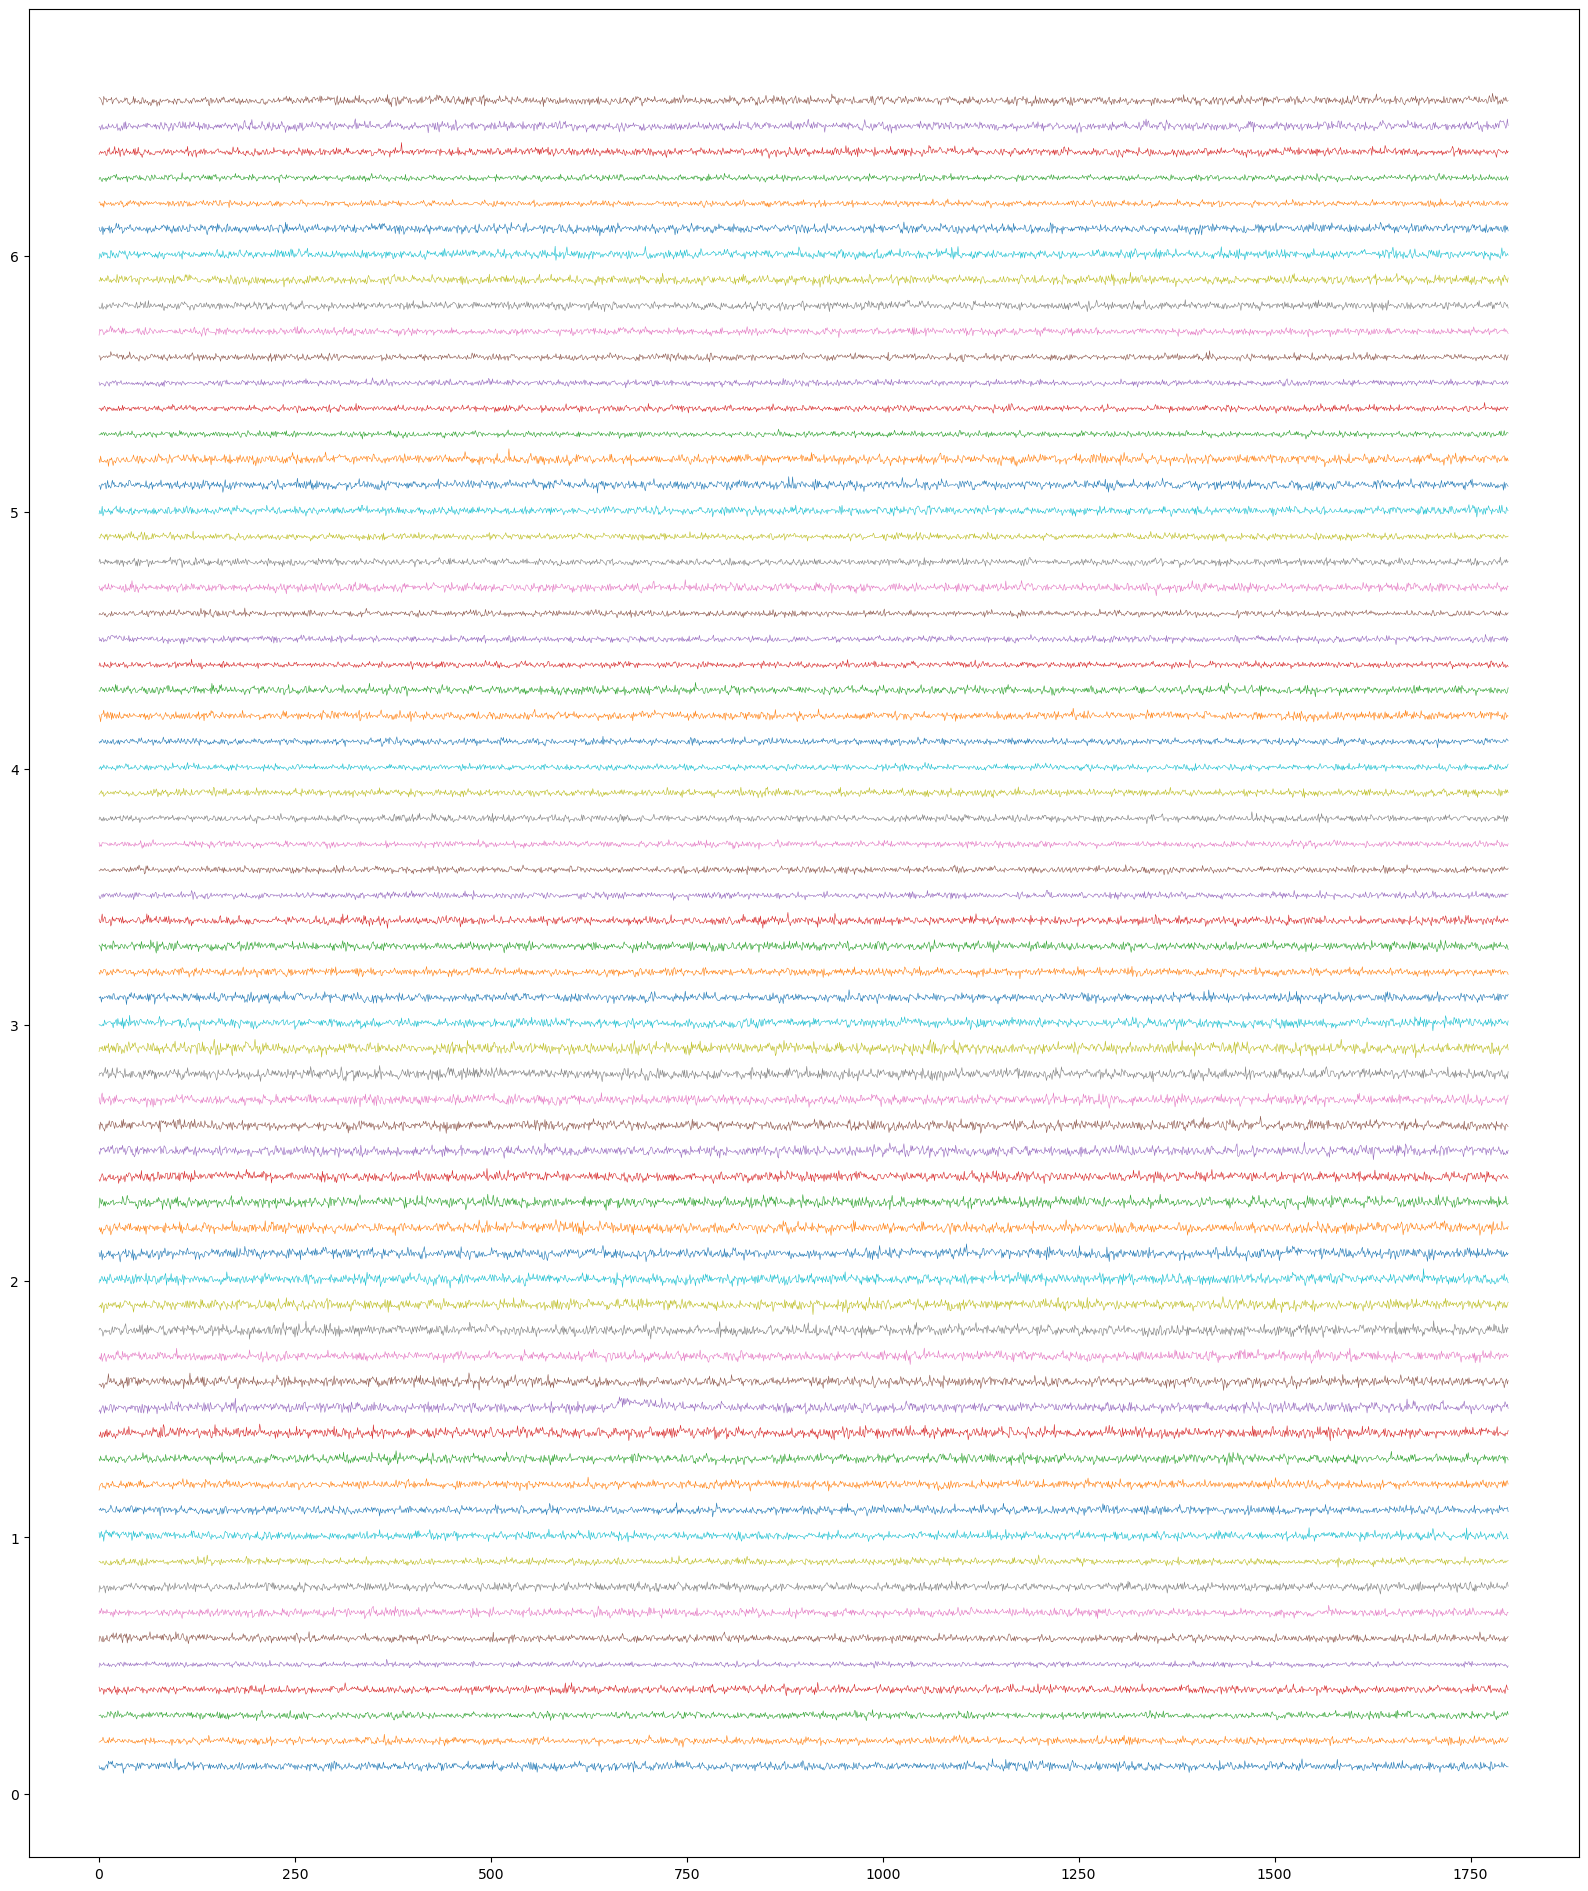

In [60]:
offset=0.1 #just for visual plotting

plt.figure(figsize=(20,24))

slope_threshold = -0.1


### SEE SOME NOISY ONES (above slope_threshold) ### 

count=0
for i in range(0,100):
    if slope[i] >slope_threshold:
        count+=1
        plt.plot(test[i]+offset*count,linewidth=.4)

Even placing the threshold at -0.4 seems to capture a lot of noise (keep in mind that some traces that are very noisy will also undulate due to background fluctuations, casting the slope to be away from 0).

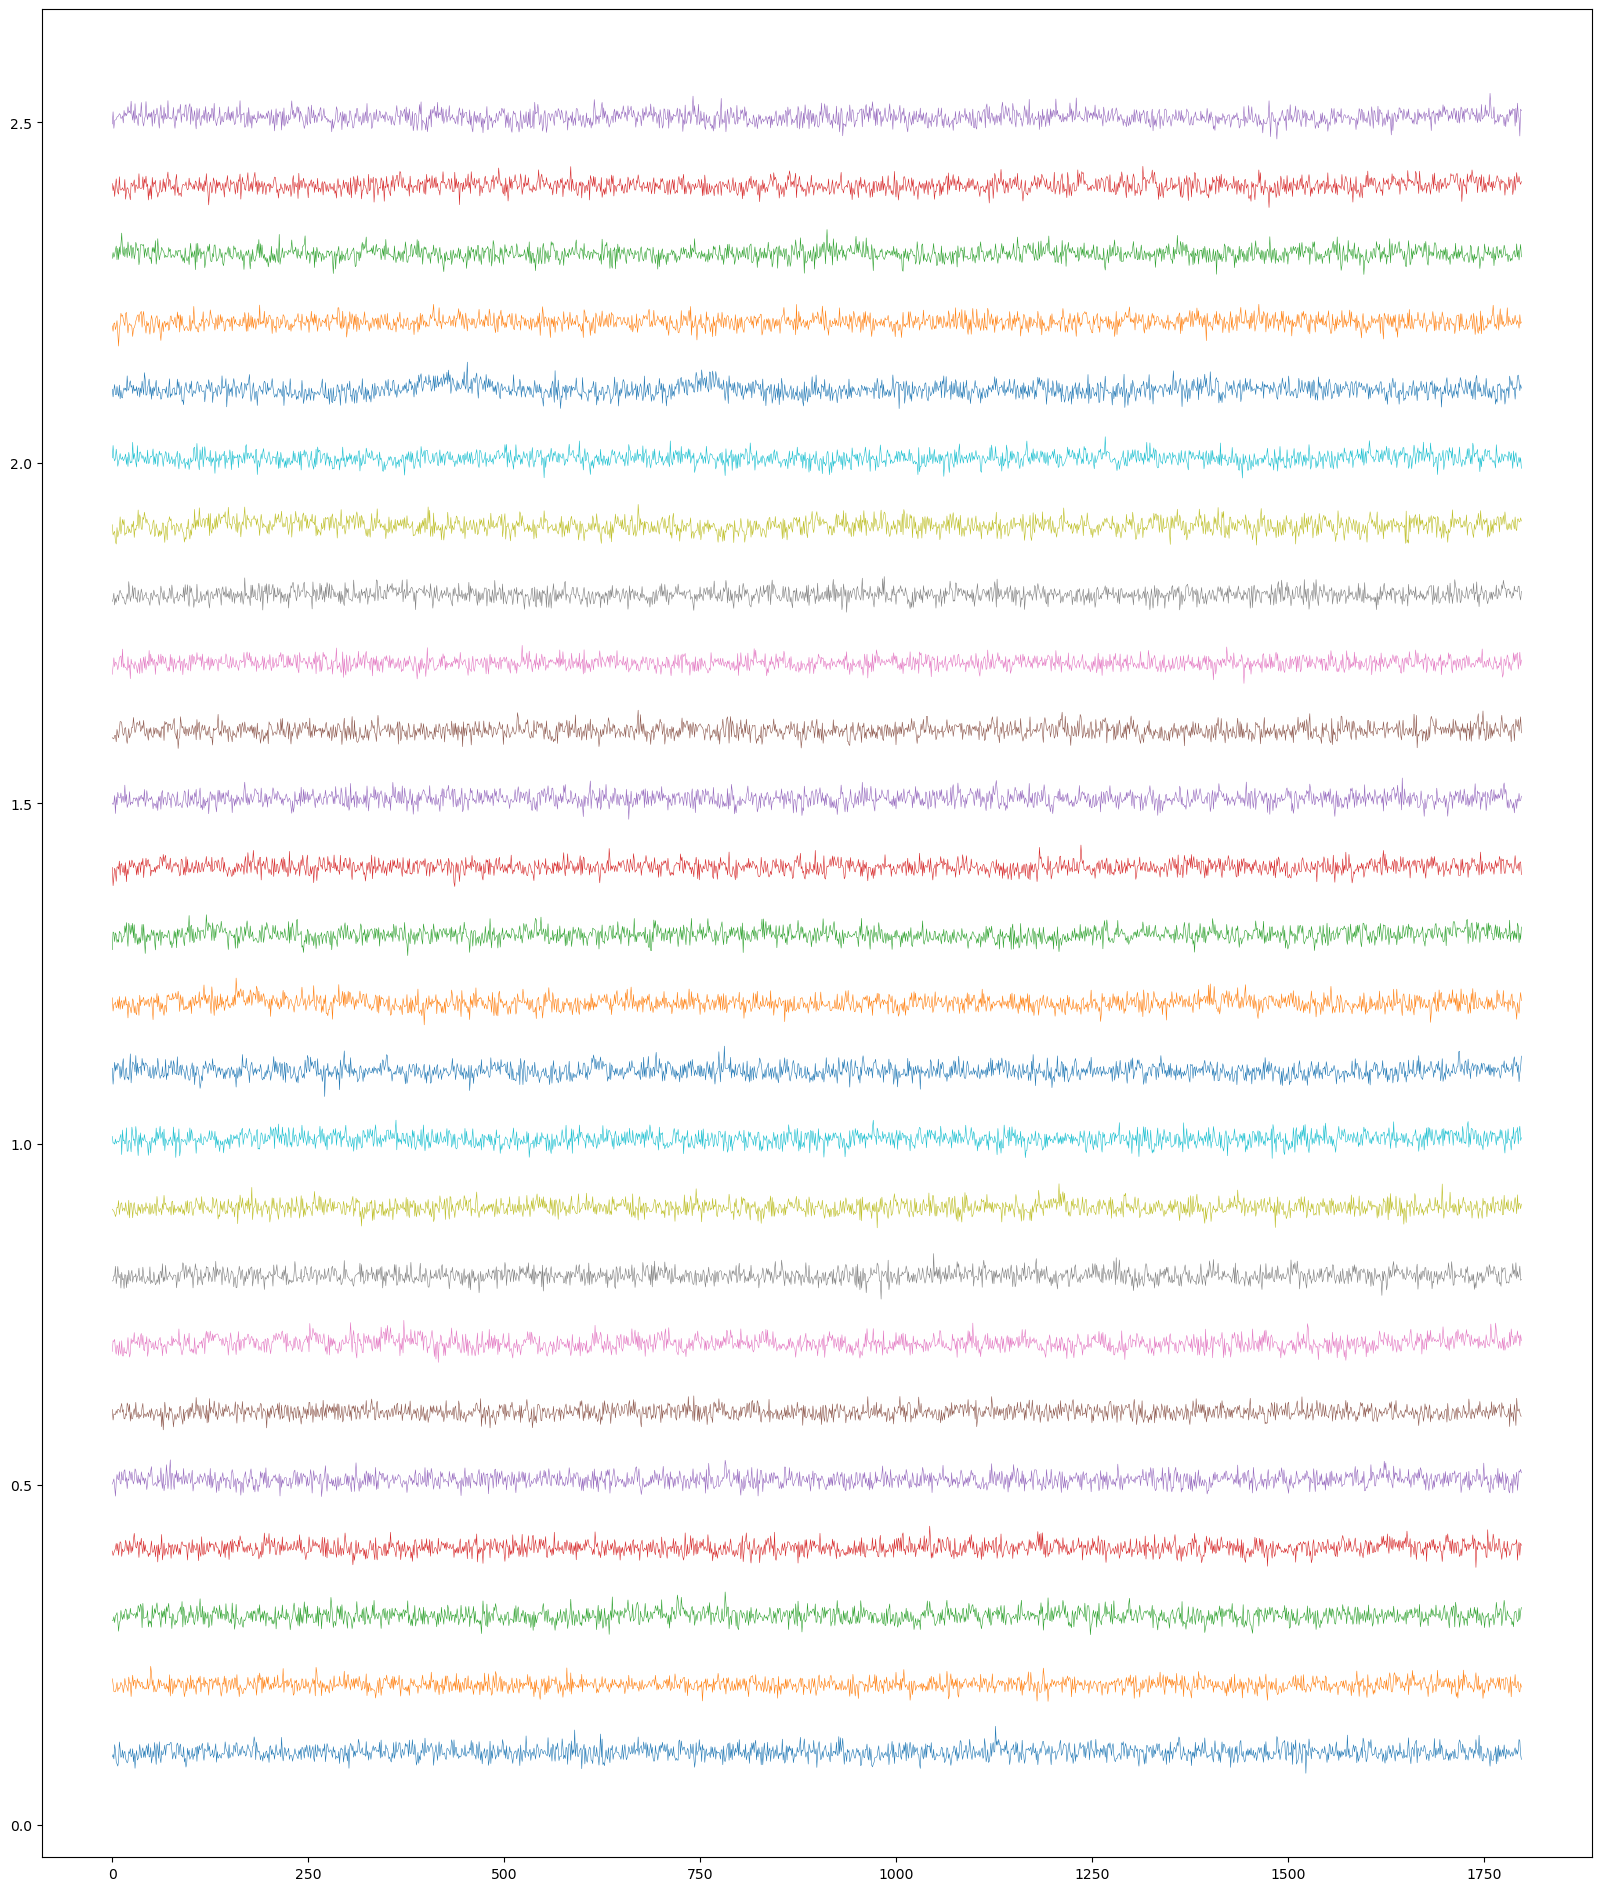

In [81]:
slope_threshold = -0.4

plt.figure(figsize=(20,24))

count=0
for i in range(0,500):
    if slope[i] > slope_threshold and slope[i] < slope_threshold+0.1: # some traces between -0.4 and -0.3
        count+=1
        plt.plot(test[i]+offset*count,linewidth=.4)

Changing the threshold to -0.7 now:

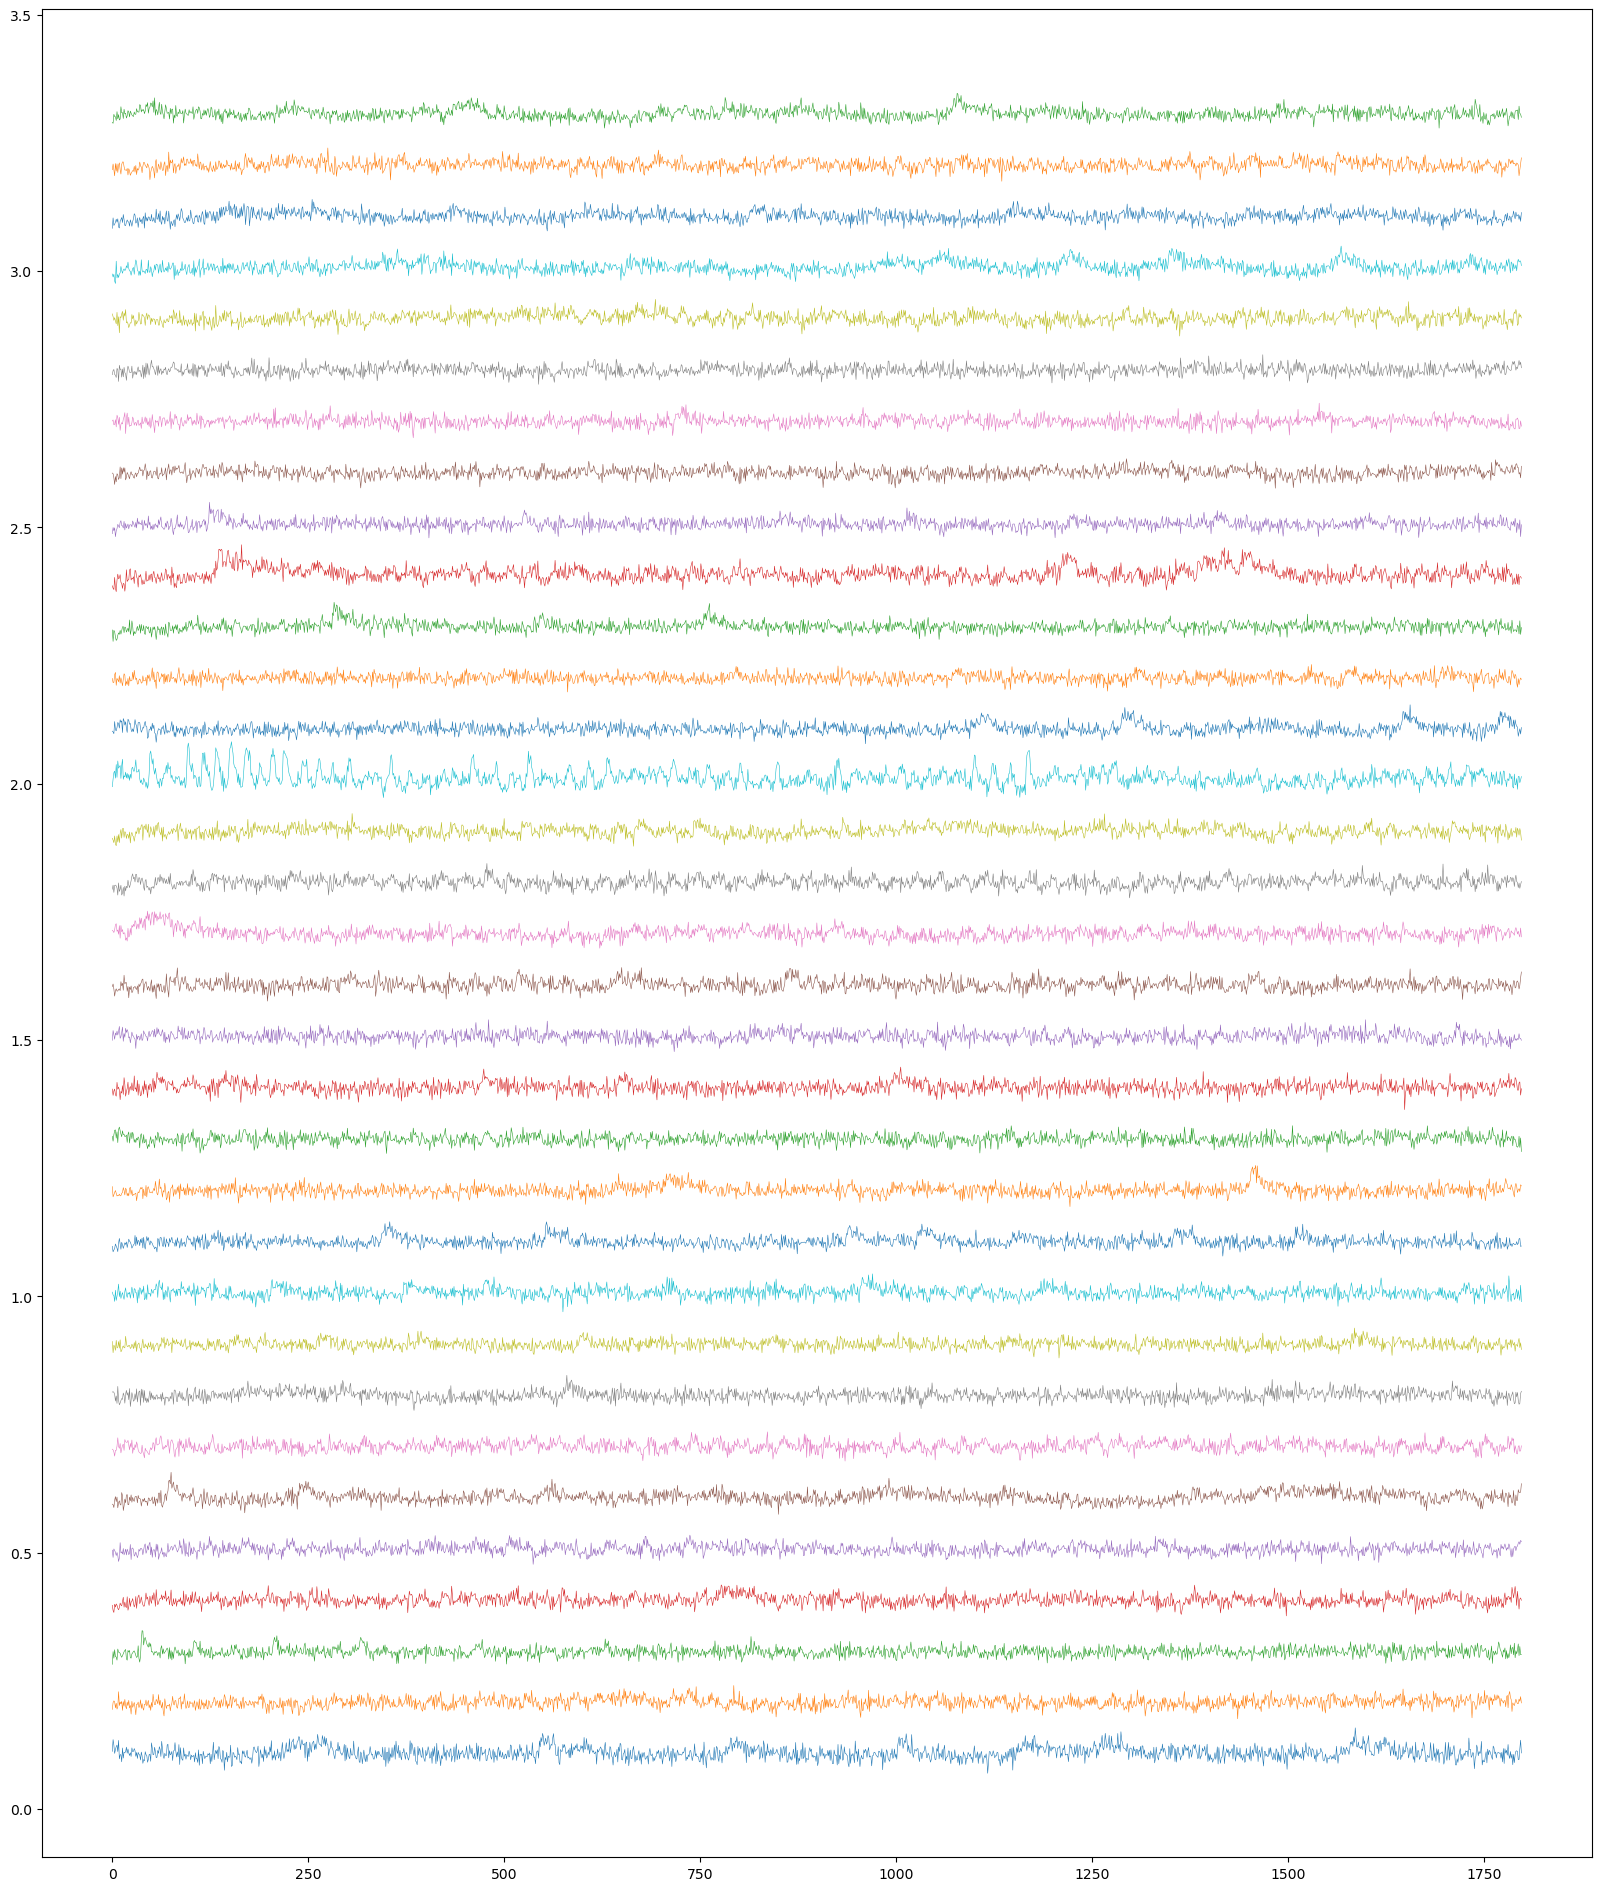

In [443]:
slope_threshold = -0.7

plt.figure(figsize=(20,24))

count=0
for i in range(0,2000):
    if slope[i] > slope_threshold and slope[i] < slope_threshold+0.1: # some traces between -0.7 and -0.6
        count+=1
        plt.plot(test[i]+offset*count,linewidth=.4)

To find which traces these correspond to:

trace no. 23 , slope  -0.993
trace no. 24 , slope  -1.837
trace no. 32 , slope  -1.585
trace no. 62 , slope  -2.071
trace no. 67 , slope  -1.323
trace no. 91 , slope  -1.824
trace no. 96 , slope  -1.878


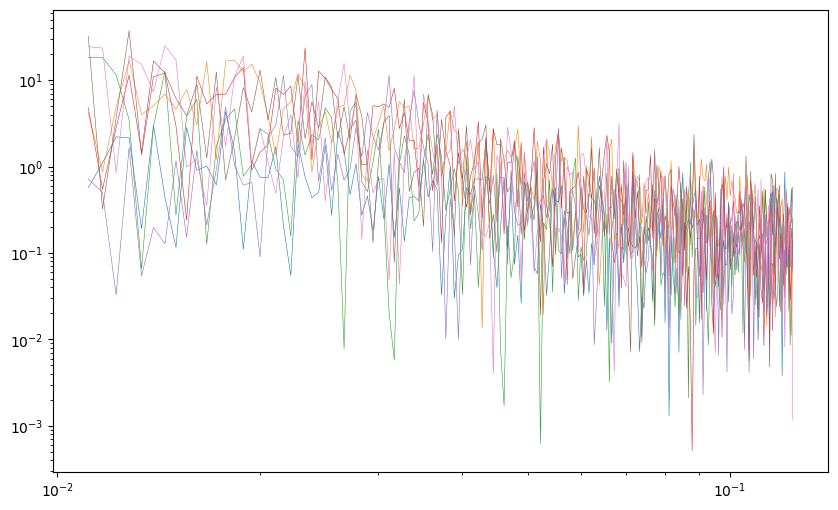

In [103]:
plt.figure(figsize=(10,6))

for i in range(100): # out of the first 100 traces, for simplicity
    if slope[i]< slope_threshold:
        trace=test[i]
        f = np.fft.fftfreq(len(trace))
        F0 = np.fft.fft(trace)  
        P0 = np.abs(F0)     
        print('trace no.',i,', slope ',np.round(slope[i],3))
        
        plt.loglog(f[20:int(cutoff/4)],P0[20:int(cutoff/4)]**2,linewidth=.4)

If you want an array of these values, then:

In [122]:
count=0
for i in range(test.shape[0]): # the entire trace
    if slope[i]< slope_threshold:
        count+=1
        
idx_filtered=np.zeros((count))
slope_filtered=np.zeros((count))


count=0
for i in range(test.shape[0]):    
    if slope[i]< slope_threshold:  
        idx_filtered[count]=i
        count+=1
        
slope_filtered=slope[filtered[:,0].astype(int)]

So, indices:

In [130]:
idx_filtered

array([  23.,   24.,   32., ..., 7359., 7365., 7371.])

And their corresponding slopes:

In [131]:
slope_filtered

array([-0.9931359 , -1.83669355, -1.58527276, ..., -1.06360645,
       -1.8942008 , -1.77266415])

Just to check that this is right:

In [132]:
print(slope[23],slope[32],slope[7365])

-0.9931359023461821 -1.585272764998105 -1.8942007987202254


They all match the order in the arrays that we created, so we are golden. 

If you need them for MATLAB, convert them to csv:

In [133]:
pd.DataFrame(idx_filtered).to_csv("idx_filtered.csv")
pd.DataFrame(slope_filtered).to_csv("slope_filtered.csv")

# Things to consider

The threshold (-0.7) was very large for to filter out most of the noisy traces. Clearly we're losing some good in the process (not much, maybe 5 or so, but still!)

Let's do some analysis again:

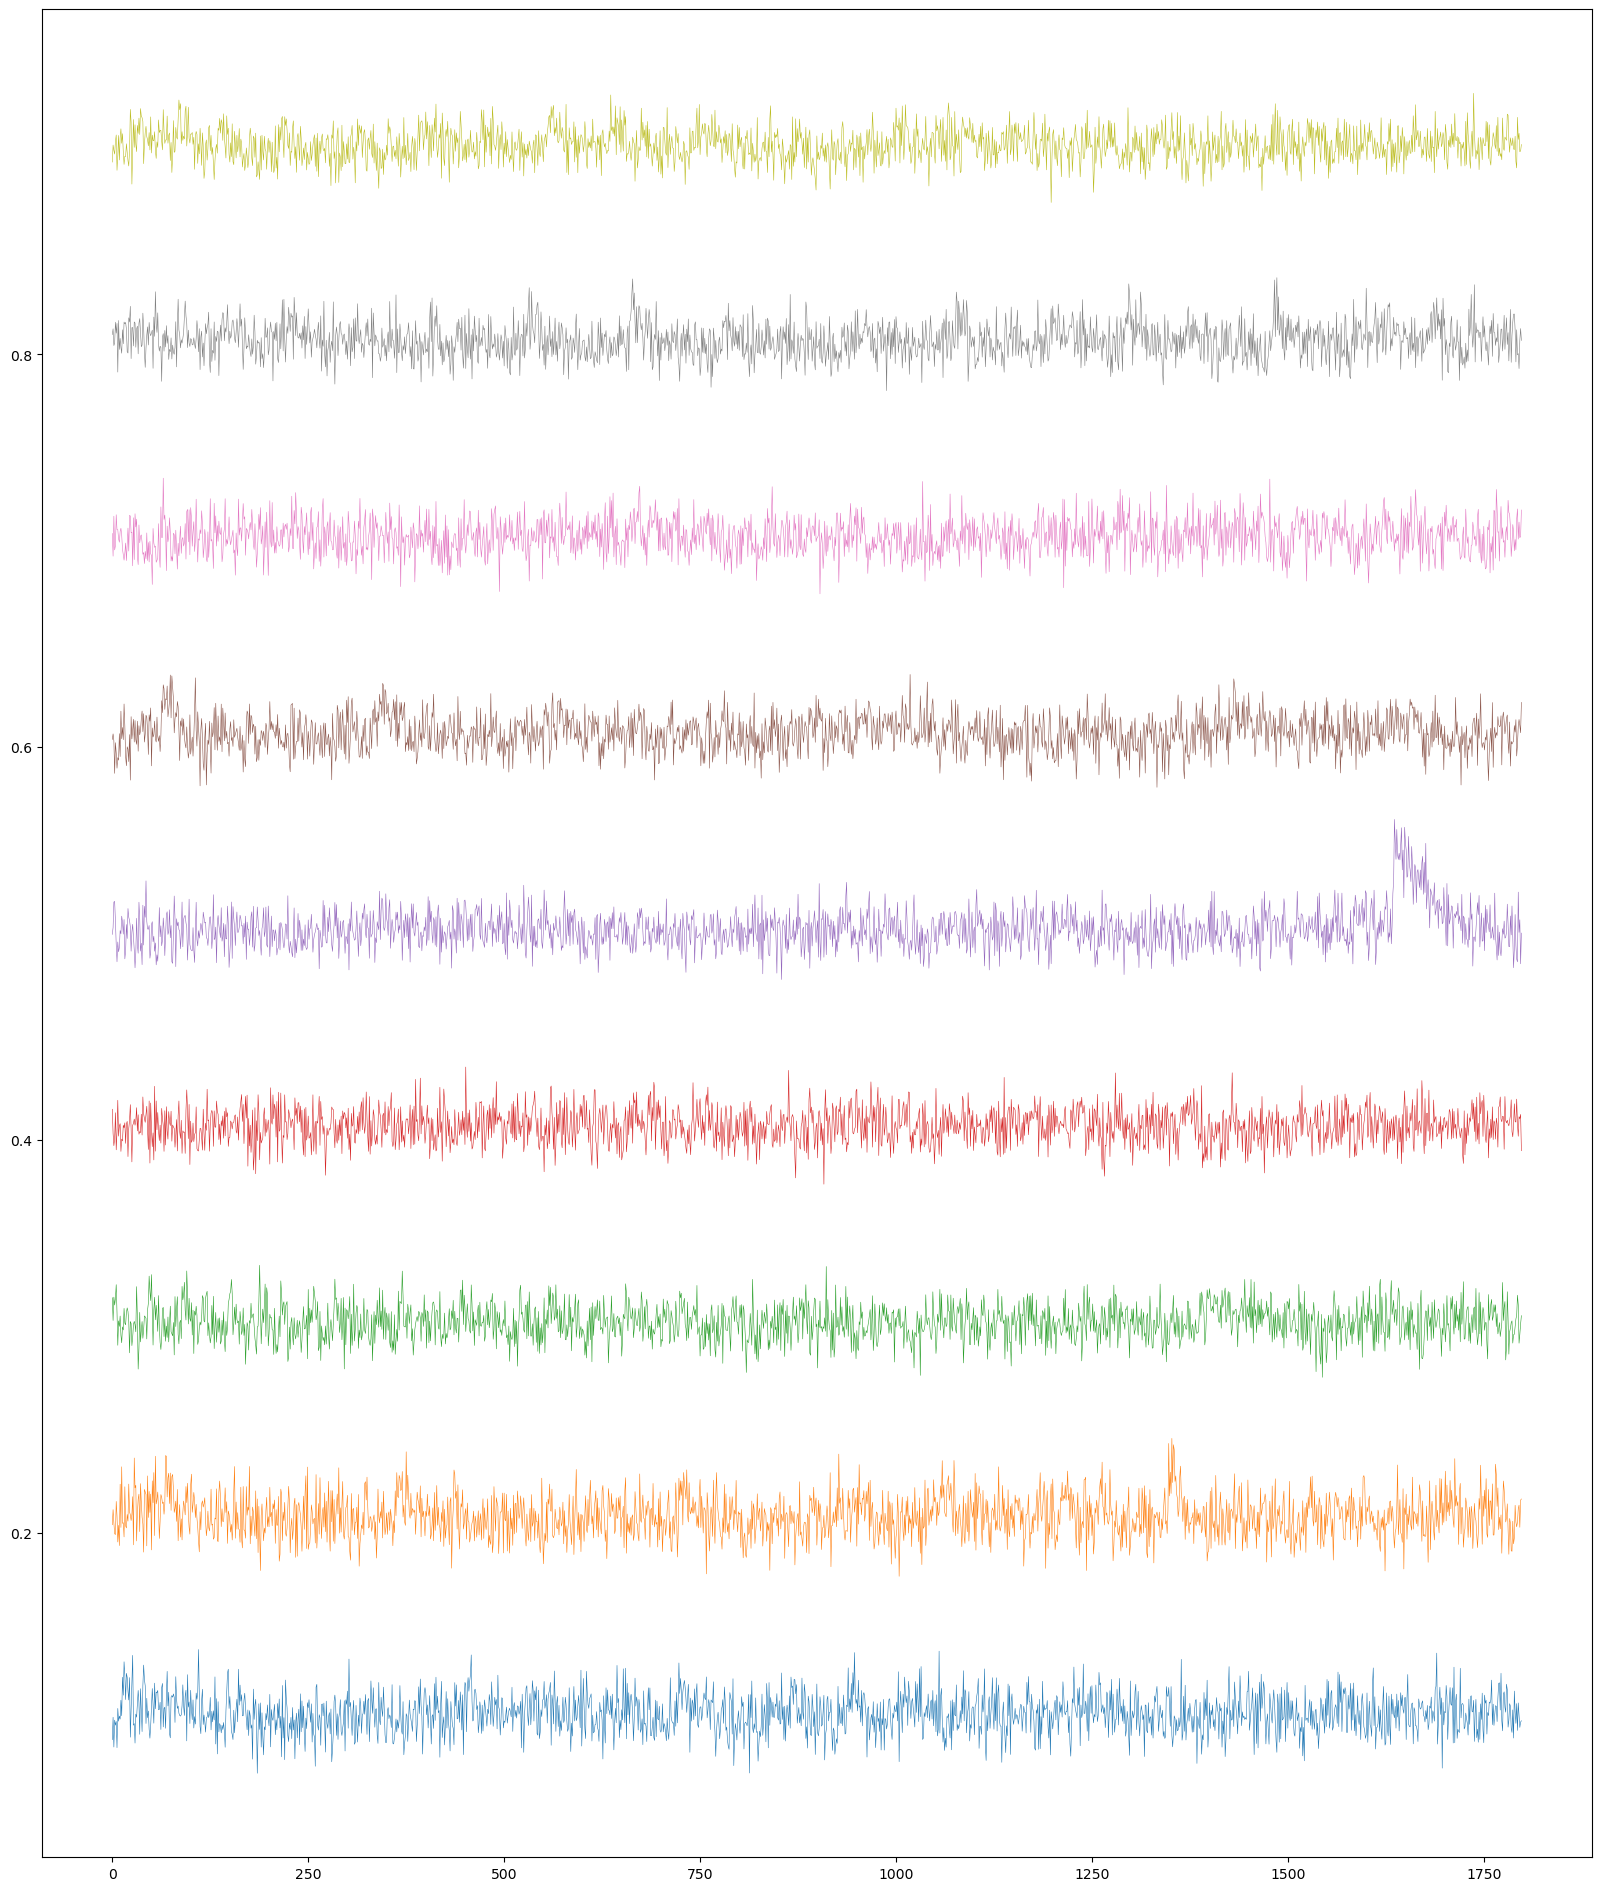

In [407]:
slope_threshold = -0.55

plt.figure(figsize=(20,24))

count=0
for i in range(0,500):
    if slope[i] > slope_threshold and slope[i] < slope_threshold+0.1: # some traces between -0.4 and -0.3
        count+=1
        plt.plot(test[i]+offset*count,linewidth=.4)

trace no. 15 , slope  -0.463
trace no. 31 , slope  -0.473
trace no. 125 , slope  -0.488
trace no. 183 , slope  -0.493
trace no. 193 , slope  -0.521
trace no. 217 , slope  -0.544
trace no. 263 , slope  -0.482
trace no. 279 , slope  -0.524
trace no. 466 , slope  -0.502


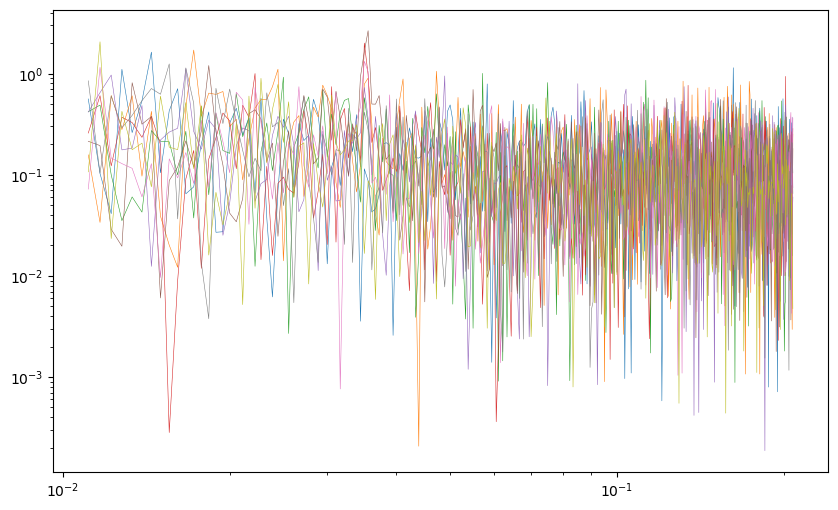

In [408]:
plt.figure(figsize=(10,6))

for i in range(500): # out of the first 100 traces, for simplicity
    if slope[i] > slope_threshold and slope[i] < slope_threshold+0.1:
        trace=test[i]
        f = np.fft.fftfreq(len(trace))
        F0 = np.fft.fft(trace)  
        P0 = np.abs(F0)     
        print('trace no.',i,', slope ',np.round(slope[i],3))
        
        plt.loglog(f[20:int(cutoff/4)],P0[20:int(cutoff/4)]**2,linewidth=.4)

Do you see the resonant peaks in some of the traces?? Because their width is so small, they're getting quenched by the white noise in the background when finding the slope. One way to circumvent this is by looking at the un-logged plot, since these will make any resonant peaks much sharper:

trace no. 15 , slope  -0.463
trace no. 31 , slope  -0.473
trace no. 125 , slope  -0.488
trace no. 183 , slope  -0.493
trace no. 193 , slope  -0.521
trace no. 217 , slope  -0.544
trace no. 263 , slope  -0.482
trace no. 279 , slope  -0.524
trace no. 466 , slope  -0.502


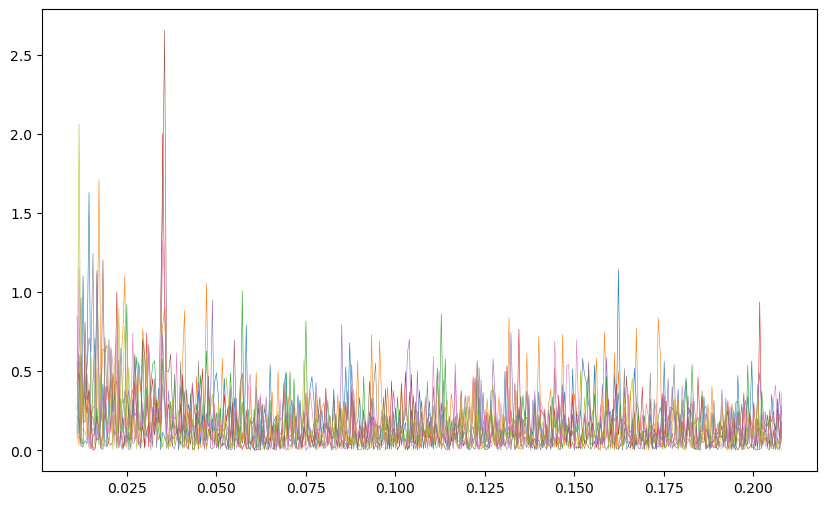

In [409]:
plt.figure(figsize=(10,6))

for i in range(500): # out of the first 100 traces, for simplicity
    if slope[i] > slope_threshold and slope[i] < slope_threshold+0.1:
        trace=test[i]
        f = np.fft.fftfreq(len(trace))
        F0 = np.fft.fft(trace)  
        P0 = np.abs(F0)     
        print('trace no.',i,', slope ',np.round(slope[i],3))
        
        plt.plot(f[20:int(cutoff/4)],P0[20:int(cutoff/4)]**2,linewidth=.4)

We definitely want to resurrect(?) as many of those as possible. However, not all of those are ones we want. For instance, a single huge peak would necessarily correspond to a simple monochromatic sine or cosine, both of which are not characteristic of the sharp-rise-slow-fall character of neural dynamics.


As an example, see this simulated trace with a little white noise added to it: 

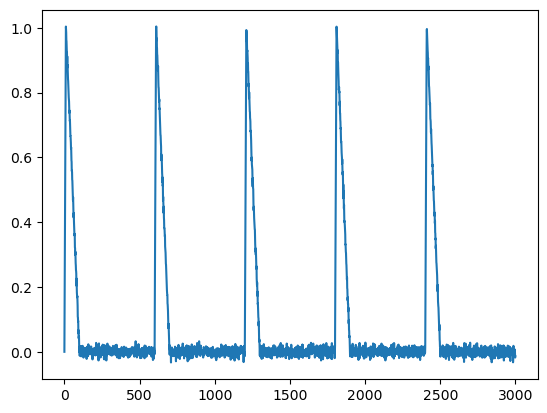

In [410]:
from scipy import signal

t = np.linspace(0, 1, 2000)
pulse=.5*signal.sawtooth(2 * np.pi * 20 * t,width=.1)+.5
length_zero=500
finalsig=np.concatenate((\
                pulse[0:100],\
                np.zeros((length_zero)),\
                pulse[100:200],\
                np.zeros((length_zero)),\
                pulse[200:300],\
                np.zeros((length_zero)),\
                pulse[300:400],\
                np.zeros((length_zero)),\
                pulse[400:500],\
                np.zeros((length_zero)),\
                
               ),axis=0)

strength_noise=.01
finalsig=finalsig+strength_noise*np.random.normal(0,1,finalsig.shape[0])

plt.plot(finalsig)

Its PSD looks like:

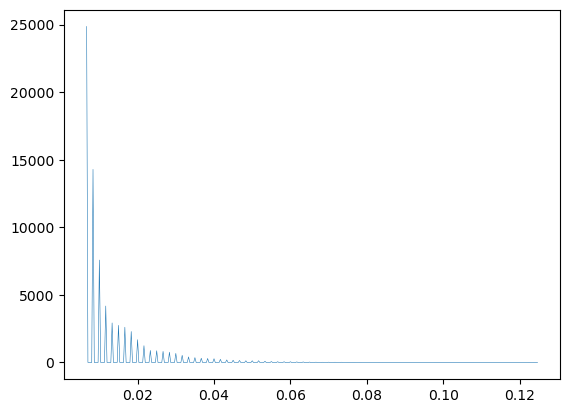

In [411]:
trace=finalsig
cutoff = int(np.floor(trace.shape[0]/2))

f = np.fft.fftfreq(len(trace))
F0 = np.fft.fft(trace)  
P0 = np.abs(F0) 

plt.plot(f[20:int(cutoff/4)],P0[20:int(cutoff/4)]**2,linewidth=.4)

So you actually want to keep "resonant" peaks in Fourier space that peak more than once---you need a distribution of these resonant peaks as they correspond to the frequency modes that yield that asymmetric shape



One crude way to do this, as I will, is imposing the filter that I want to keep traces that cross an intensity of __resonance_threshold__ at least __peak_threshold__ times.

no. of traces satisfying the peak criterion, with slopes between -0.55 and -0.45 :  1
total no. of traces with slopes between -0.55 and -0.45 :  332


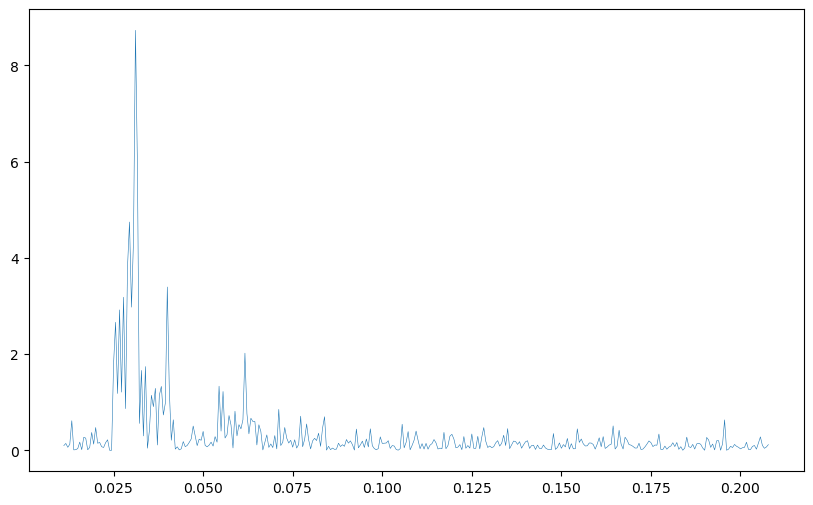

In [425]:
plt.figure(figsize=(10,6))


##### adjust parameters #####
resonance_threshold=3
peak_threshold=5
#############################

resonance_count=0
for i in range(test.shape[0]): # changed to all traces
    if slope[i] > slope_threshold and slope[i] < slope_threshold+0.1:
        trace=test[i]
        f = np.fft.fftfreq(len(trace))
        F0 = np.fft.fft(trace)  
        P0 = np.abs(F0)     
        
        if ((len(np.where(P0[20:int(cutoff/4)]**2>resonance_threshold)[0]))>peak_threshold)==1:
        # if np.any(P0[20:int(cutoff/4)]**2>resonance_threshold)==1:
            plt.plot(f[20:int(cutoff/4)],P0[20:int(cutoff/4)]**2,linewidth=.4)
            resonance_count+=1
        

idx_resonance = np.zeros((resonance_count))
resonance_count=0
slope_count=0
for i in range(test.shape[0]):
    if slope[i] > slope_threshold and slope[i] < slope_threshold+0.1:
        slope_count+=1
        trace=test[i]
        f = np.fft.fftfreq(len(trace))
        F0 = np.fft.fft(trace)  
        P0 = np.abs(F0)     
        
        
        if ((len(np.where(P0[20:int(cutoff/4)]**2>resonance_threshold)[0]))>peak_threshold)==1:
        # if np.any(P0[20:int(cutoff/4)]**2>resonance_threshold)==1:               
            idx_resonance[resonance_count]=i
            resonance_count+=1
    
idx_resonance.astype(int);

print(f"no. of traces satisfying the peak criterion, with slopes between {slope_threshold} and {np.round(slope_threshold+0.1,2)} : ",resonance_count)
print(f"total no. of traces with slopes between {slope_threshold} and {np.round(slope_threshold+0.1,2)} : ",slope_count)

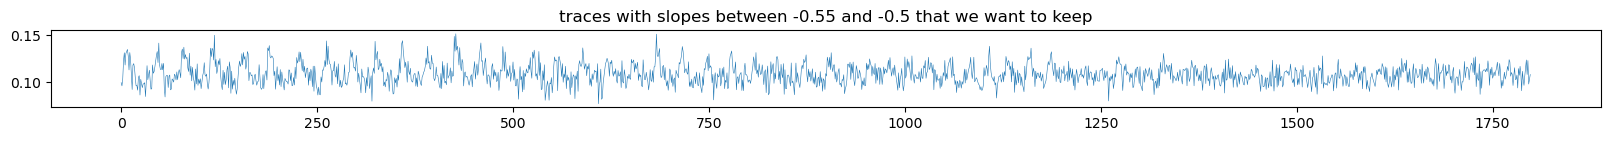

In [426]:
plt.figure(figsize=(20,idx_resonance.shape[0]))

count=0
for i in range(0,test.shape[0]):
    if slope[i] > slope_threshold and slope[i] < slope_threshold+0.1 and i in idx_resonance: # some traces between -0.4 and -0.3
        
        count+=1
        
        plt.plot(test[i]+offset*count,linewidth=.4)
        plt.title(f'traces with slopes between {slope_threshold} and {np.round(slope_threshold+0.1,1)} that we want to keep')